In [1]:
import numpy as np
import imageio
import sys
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
imageio.plugins.freeimage.download()
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:

def load_normal_reals(file):
    normal_files = glob.glob(file)[:100]

    normals = []
    print(len(normal_files))
    for normal_file in normal_files:
        imarr = imageio.imread(normal_file)[1:-1,1:-1,:]
        imarr[~np.isfinite(imarr)] = 0
        normals.append((imarr.reshape(-1, 3) - 0.5) * 2)

    normals = np.array(normals)
    return normals

In [75]:
from scipy.stats import gaussian_kde

def beckmann(theta, alpha):
    u = np.cos(theta)
    
    alphaSq = alpha*alpha
    cosThetaSq = np.cos(theta)**2
    tanThetaSq = np.maximum(1.0 - cosThetaSq, 0.0)/cosThetaSq
    cosThetaQu = cosThetaSq*cosThetaSq
    res = (1.0/np.pi)*np.exp(-tanThetaSq/alphaSq)/(alphaSq*cosThetaQu)
    
    return np.where(u > 0, res, 0)

def plot_normal_collection(normals, label, file, beckmann_roughness=0, bounds=((None, None), (None, None))):
    #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig, axs = plt.subplots(1,2 if beckmann_roughness != 0 else 1)

    ax = axs[0] if beckmann_roughness != 0 else axs

    hist, X, Y = np.histogram2d(
          normals[0][0][:,0], 
          normals[0][0][:,1], bins=(50, 50), range=bounds, density=True)
    
    max = np.max(hist)

    #A, R = np.meshgrid(abins, rbins)
    pc = ax.pcolormesh(X, Y, hist.T, vmin=0, vmax=max)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    #fig.colorbar(pc, cax=cax, orientation='vertical')
    
    #fig.colorbar(pc)


    if beckmann_roughness != 0:
        bnormals = np.reshape(np.fromfile(f"visible-normals/beckmann-{beckmann_roughness}.bin", dtype=np.float32), (3,-1)).T
        beckmann_hist, X, Y = np.histogram2d(
          bnormals[:,0], 
          bnormals[:,1], bins=(50, 50), density=True)

        axs[1].pcolormesh(X, Y, hist.T - beckmann_hist.T, vmin=0, vmax=max)

        axs[1].set_ylim(-1,1)
        axs[1].set_xlim(-1,1)
        axs[1].set_facecolor("black")
        axs[1].grid(False)
        axs[1].set_yticks([])
        axs[1].set_title("Beckmann")
        #ax.xlabel("$n_x$")
        #ax.ylabel("$n_y$")
        axs[1].set_aspect("equal")
        fig.tight_layout()

    #ax.scatter(np.arctan2(normals[:,1], normals[:,0]), np.sqrt(normals[:,0]**2 + normals[:,1]**2), s=0.2, alpha=0.02, color="white")
    ax.set_xlim(*bounds[0])
    ax.set_ylim(*bounds[1])
    ax.set_facecolor("black")
    ax.grid(False)
    ax.set_title(label)
    #ax.xlabel("$n_x$")
    #ax.ylabel("$n_y$")
    ax.set_aspect("equal")
    fig.tight_layout()

    dir = os.path.join("plots",os.path.split(file)[0])
    os.makedirs(dir, exist_ok=True)
    #fig.savefig(os.path.join(dir, os.path.basename(file)[:-3] + "png"), dpi=300)

def plot_normal_collection_1D(normals, label, file, beckmann_roughness=0, vmf_kappa=0):
    #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig, ax = plt.subplots(figsize=(1.5,1.5))

    # define binning
    rbins = np.linspace(-1, 1, 30)

    for n,l in normals:
        z_vals = n[:,2]+ np.random.normal(0,0.0001, n.shape[0])
        z_vals = np.clip(z_vals,-1, 1)
        hist, bins = np.histogram(z_vals, weights=np.ones_like(z_vals)/(z_vals.shape[0]), bins=rbins, density=False)
        bins = rbins[1:]
        ax.plot(bins, hist, label=l)

    #hist *= (2.5*np.pi)

    #density = gaussian_kde(z_vals)
    #ax.plot(bins,density(bins), alpha=0.4)


    if beckmann_roughness != 0:
        bnormals = np.reshape(np.fromfile(f"visible-normals/beckmann-{beckmann_roughness}.bin", dtype=np.float32), (3,-1)).T
        z_vals = bnormals[:,2]+ np.random.normal(0,0.0001, bnormals.shape[0])
        z_vals = np.clip(z_vals,-1, 1)
        hist, bins = np.histogram(z_vals, weights=np.ones_like(z_vals)/(z_vals.shape[0]), bins=rbins, density=False)
        bins = rbins[1:]
        ax.plot(bins, hist, label="beckmann", linestyle="--", alpha=0.5)


    if vmf_kappa != 0:
        b = st.vonmises.pdf(np.arccos(bins), vmf_kappa) / (np.pi)
        plt.plot(bins, b, label='vMF')

    ax.set_xlim(0,1)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(label)
    #ax.set_xlabel("$n_z$")
    #ax.legend()
    #ax.ylabel("$n_y$")
    #ax.set_theta_zero_location("N")
    #ax.set_aspect("equal")
    fig.tight_layout()

    dir = os.path.join("plots",os.path.split(file)[0])
    os.makedirs(dir, exist_ok=True)
    #fig.savefig(os.path.join(dir, os.path.basename(file)[:-4] + "-1D.pdf"), dpi=300, bbox_inches='tight',pad_inches=0)
    



c:\Users\dario\.conda\envs\research\lib\site-packages\numpy\lib\histograms.py:1065: RuntimeWarning: invalid value encountered in divide
  hist /= s


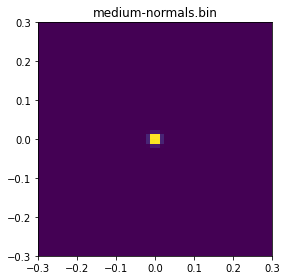

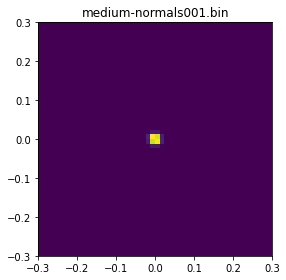

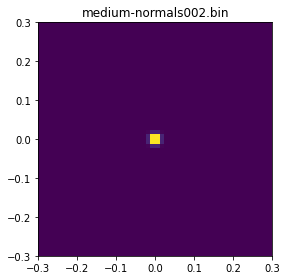

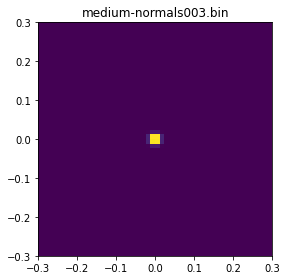

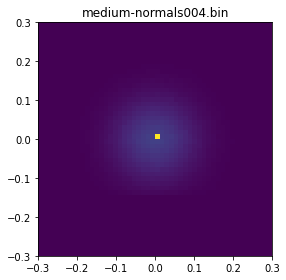

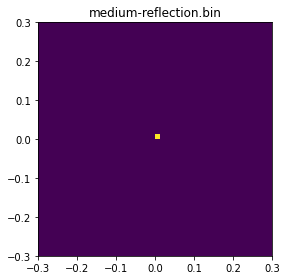

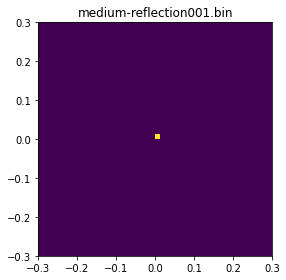

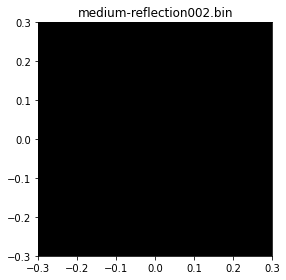

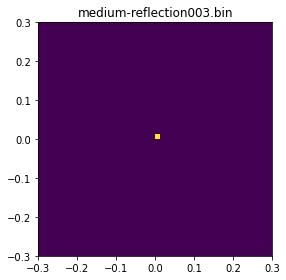

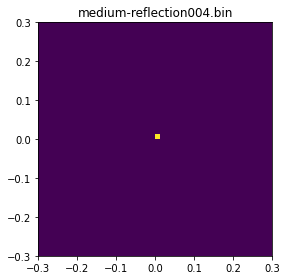

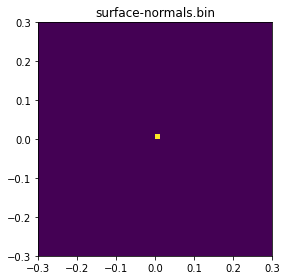

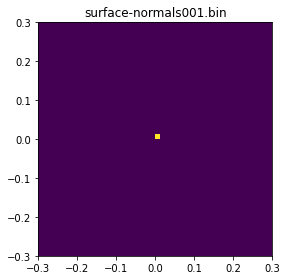

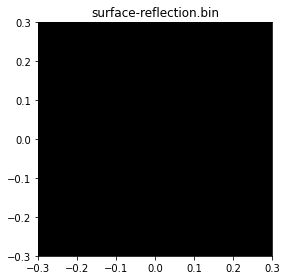

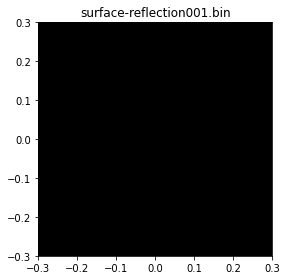

In [79]:

with plt.style.context("seaborn-v0_8-dark"):
    params = {'text.usetex' : True,
            'font.size' : 7,
            'font.family' : 'Linux Libertine'}
    plt.rcParams.update(params)

def br(L2):
    return np.sqrt(2*L2)



normal_files = dict()
for file in glob.glob("../testing/intersections/*.bin"):
#for file in glob.glob("normals-validate-nocond/se/*.bin"):
    if "old" in file or "realizations" in file or "failed" in file:
        continue
    normals = np.reshape(np.fromfile(file, dtype=np.float32), (3,-1)).T
    
    deg_idx = file.find("deg")
    deg_idx = deg_idx if deg_idx != -1 else -4

    key = file # file[:deg_idx+3] + ".bin"
    if key not in normal_files:
        normal_files[key] = []

    normal_files[key].append((normals, file[deg_idx+3:-4]))
    #plot_normal_collection(normals, file[len("visible-normals/"):], file)

common_prefix = os.path.commonprefix(list(normal_files.keys()))
    
for k, v in normal_files.items():
    if "l=1" in k:
        beckmann_roughness = np.sqrt(2)
    elif "l=0.5" in k:
        beckmann_roughness = 2*np.sqrt(2)
    elif "l=0.1" in k:
        beckmann_roughness = 10*np.sqrt(2)

    #plot_normal_collection_1D(v, k[len("visible-normals/"):], k, 
    #                        beckmann_roughness=np.round(beckmann_roughness, 4))

    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)) if "normals" in k else ((-0.01, 0.01), (-1, -0.98)))
    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)))
    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.3, 0.3), (-0.3, 0.3)))
    plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-1, 1), (-1, 1)))




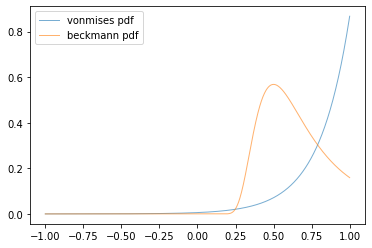

In [5]:




kappa = 5

u = np.linspace(-1, 1, 1000)
pdf = st.vonmises.pdf(np.arccos(u), kappa)

b = beckmann(np.arccos(u), 1.41421)

#z = np.cos(theta)
#pdf = pdf * np.sin(theta)


plt.plot(u, pdf, lw=1, alpha=0.6, label='vonmises pdf')
plt.plot(u, b, lw=1, alpha=0.6, label='beckmann pdf')
plt.legend()